# Confusion Matrix and ROC Curve

### Import required libraries

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.metrics import auc, average_precision_score

from imblearn.combine import SMOTETomek

### Read Preprocessed data

In [89]:
df = pd.read_csv("data/preprocessed_data.csv", index_col=0)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,NewAGT,CreditsScore,AgeScore,BalanceScore,EstSalaryScore,NewEstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard,IsActiveMember,Exited
RowNumber,,,,,,,,,,,,,,,,,,,,
1,-0.246269,0.416667,-0.75,-0.761480,0.0,0.011739,0.666667,-0.2,0.50,-0.9,0.1,0.011739,1,0,0,1,0,1,1,1
2,-0.328358,0.333333,-1.00,-0.104906,0.0,0.125512,0.666667,-0.2,0.50,-0.1,0.1,0.125512,0,0,1,1,0,0,1,0
3,-1.119403,0.416667,0.75,0.489346,2.0,0.139630,0.166667,-0.8,0.50,0.9,0.1,0.139630,1,0,0,1,0,1,0,1
4,0.350746,0.166667,-1.00,-0.761480,1.0,-0.064717,0.500000,0.4,0.25,-0.9,-0.1,-0.064717,1,0,0,1,0,0,0,0
5,1.477612,0.500000,-0.75,0.221806,0.0,-0.214561,0.750000,1.0,0.50,0.5,-0.3,-0.214561,0,0,1,1,0,1,1,0


### Train best performing model with opitmal hyperparameters from GridSearch

In [90]:
X = df.drop(["Exited"], axis = 1)
y = df["Exited"]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=12345)

In [92]:
smk = SMOTETomek()

X_train, y_train = smk.fit_sample(X_train, y_train)
X_test, y_test = smk.fit_sample(X_test, y_test)

In [93]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12682, 19) (3122, 19) (12682,) (3122,)


In [94]:
model = LGBMClassifier(random_state = 12345,  learning_rate = 0.05, max_depth = 5, n_estimators = 1000)
base = model.fit(X_train,y_train)
y_pred = base.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

## Confusion Matrix
### Is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.

In [95]:
confusion_matrix(y_test, y_pred)

array([[1487,   74],
       [ 228, 1333]], dtype=int64)

In [96]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  1487
False Positives:  74
False Negatives:  228
True Positives:  1333


## Evaluating the model

In [97]:
def confusion_matrix_analysis(true,pred):
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    f_score = 2*precision*tpr/(precision+tpr)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    print("Precision:\t\t\t%1.2f identified as mines are mines"%(precision))
    print("Recall/TPR:\t\t\t%1.2f proportion of actual mines identified"%(tpr))
    print("False Positive Rate:\t\t%1.2f proportion of rocks identified as mines"%fpr)
    print("f-score:\t\t\t%1.2f tradeoff between precision and recall"%(f_score))
    print("Accuracy:\t\t\t%1.2f how well the model has classified"%(accuracy))

In [98]:
confusion_matrix_analysis(y_test,y_pred)

Precision:			0.95 identified as mines are mines
Recall/TPR:			0.85 proportion of actual mines identified
False Positive Rate:		0.05 proportion of rocks identified as mines
f-score:			0.90 tradeoff between precision and recall
Accuracy:			0.90 how well the model has classified


## ROC Curve (receiver operating characteristic curve)
### Is a graph showing the performance of a classification model at all classification thresholds. AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve. AUC provides an aggregate measure of performance across all possible classification thresholds.

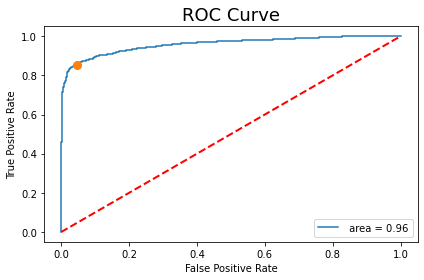

In [99]:
lbgm_tuned = model
y_pred_prob = lbgm_tuned.predict_proba(X_test)[:,1]
fig, ax = plt.subplots()
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr,tpr)
ax.plot(fpr,tpr, label = " area = {:0.2f}".format(roc_auc))
ax.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
ax.set_xlabel("False Positive Rate", fontsize = 10)
ax.set_ylabel("True Positive Rate", fontsize = 10)
ax.set_title("ROC Curve", fontsize = 18)
ax.legend(loc = 'best')

close_default = np.argmin(np.abs(thresholds_roc - 0.5))
ax.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
plt.tight_layout()